# Prepare environment

In [1]:
!source .venv/bin/activate

# Imports

In [2]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
import pandas as pd
import mlflow
from mlflow.models import infer_signature, set_signature
import mlflow.keras
import yaml
from pickle import dump
import math
import os
import shutil
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta

with open('thermostat.yaml', 'r') as file:
    variables = yaml.safe_load(file)

print(f"{variables}")

2024-04-03 02:06:57.570578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 02:06:57.601126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 02:06:58.263265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


{'influx_db': {'url': 'https://influxdb.ap-home', 'org': 'openhab', 'token': 'U3b0bON--ptBSPLxXySbF5in5K0wxAwdmBv1J6tR-lFAEr6uW0wRqAWmo7elPMJYmmoE1tBQjFC3o0twEJfXFg=='}, 'mlflow': {'url': 'https://mlflow.ap-home'}, 'data': ['ha_started', 'in_the_area', 'presence', 'in_bed', 'openweathermap_temperature', 'cloudliness', 'thermostat_base_heating_sp', 'living_room_occupancy', 'sun:elevation:mean', 'humidity_setpoint', 'house_humidity', 'water_heater_low_heat', 'thermostat_base_cooling_sp', 'total_radiations', 'openweathermap_cloud_coverage', 'outdoor_temperature_increasing_2', 'outdoor_temperature_decreasing', 'thermostat:temperature:mean', 'thermostat:target_temp_high:mean', 'thermostat:target_temp_low:mean', 'thermostat:state', 'openings', 'electricity_peak_cost', 'multisensor_air_temperature'], 'features': ['in_the_area', 'presence', 'in_bed', 'openweathermap_temperature', 'outdoor_temperature_increasing_2', 'outdoor_temperature_decreasing', 'thermostat_base_heating_sp', 'living_room_oc

# Load data

In [3]:
client = influxdb_client.InfluxDBClient(
    url=variables["influx_db"]["url"],
    token=variables["influx_db"]["token"],
    org=variables["influx_db"]["org"],
    verify_ssl=False,
    timeout=3600000
)

query_api = client.query_api()

# range = start: 2022-01-01T00:00:00Z, stop: 2023-08-21T09:30:30Z)
start_time = "2022-01-01T00:00:00Z"
query_start = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ") - timedelta(days=5) 

base_query = """
        from(bucket: "homeassistant")
            |> range(start: )
            |> filter(fn: (r) => r["entity_id"] == "entity_name")
            |> filter(fn: (r) => r["_field"] == "value")
            |> fill(usePrevious: true)
            |> drop(columns: ["result", "table", "_start", "_stop", "_field", "source","domain","_measurement", "friendly_name"])
            |> pivot(rowKey: ["_time"], columnKey: ["entity_id"], valueColumn: "_value")
            |> yield(name: "last")"""
base_query = base_query.replace("start: ", f'start: {datetime.strftime(query_start, "%Y-%m-%dT%H:%M:%SZ")}')
for nb, entity in enumerate(variables["data"]):
    print(entity)
    entity = entity.split(":")
    query = base_query.replace("entity_name", entity[0], 1)
    if len(entity)> 1 and {entity[1]} != "":
        query = query.replace('r["_field"] == "value"', f'r["_field"] == "{entity[1]}"')
        query = query.replace('columnKey: ["entity_id"]', f'columnKey: ["_field"]')
        query = query.replace(
            'drop(columns: ["result", "table", "_start", "_stop", "_field", "source","domain","_measurement", "friendly_name"])',
            'drop(columns: ["result", "table", "_start", "_stop", "entity_id", "source","domain","_measurement", "friendly_name"])'
        )
    if len(entity)> 2 and {entity[2]} != "":
       query = query.replace('fn: last,', f'fn: {entity[2]},')
    # print(query)
    df = query_api.query_data_frame(query, org=variables["influx_db"]["org"])
    print(df.head())
    try:
        df.set_index('_time', inplace=True)
        df.drop(["result", "table"], axis=1, inplace=True)
        if nb == 0:
            full_df = df.copy()
        else:
            full_df = full_df.join(df,on="_time", how='outer')
    except KeyError:
        print(f"{entity[1]} was not found")
        if len(entity)> 2:
            full_df[entity[1]] =  entity[2]
        else: 
            full_df[entity[1]] = np.nan

full_df.head()

ha_started
  result  table                            _time  ha_started
0   last      0 2024-02-15 20:52:54.449147+00:00         0.0
1   last      0 2024-02-15 20:54:14.248861+00:00         1.0
2   last      0 2024-02-16 00:33:15.867404+00:00         0.0
3   last      0 2024-02-16 00:35:30.212120+00:00         0.0
4   last      0 2024-02-16 00:37:03.224660+00:00         1.0
in_the_area


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  in_the_area
0   last      0 2021-12-27 06:42:47.249077+00:00          1.0
1   last      0 2021-12-27 07:05:04.196674+00:00          0.0
2   last      0 2021-12-27 07:05:38.366981+00:00          1.0
3   last      0 2021-12-27 08:09:26.085641+00:00          0.0
4   last      0 2021-12-27 08:09:47.785437+00:00          1.0
presence


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  presence
0   last      0 2021-12-27 06:42:47.246690+00:00       1.0
1   last      0 2021-12-27 07:05:04.195767+00:00       0.0
2   last      0 2021-12-27 07:05:38.365327+00:00       1.0
3   last      0 2021-12-27 08:09:26.084493+00:00       0.0
4   last      0 2021-12-27 08:09:47.783601+00:00       1.0
in_bed


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  in_bed
0   last      0 2021-12-27 06:42:47.260392+00:00     0.0
1   last      0 2021-12-27 07:05:04.201661+00:00     0.0
2   last      0 2021-12-27 08:09:26.088733+00:00     0.0
3   last      0 2021-12-27 08:30:01.442487+00:00     1.0
4   last      0 2021-12-27 10:53:44.434106+00:00     0.0
openweathermap_temperature


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  openweathermap_temperature
0   last      0 2021-12-27 00:05:05.589065+00:00                       -0.23
1   last      0 2021-12-27 00:15:05.668450+00:00                       -0.21
2   last      0 2021-12-27 00:35:05.719533+00:00                       -0.31
3   last      0 2021-12-27 00:45:05.610818+00:00                       -0.35
4   last      0 2021-12-27 00:55:05.616188+00:00                       -0.51
cloudliness


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  cloudliness
0   last      0 2021-12-27 07:40:08.617290+00:00        0.001
1   last      0 2021-12-27 18:54:24.652019+00:00        0.001
2   last      0 2021-12-27 22:53:28.671523+00:00        0.001
3   last      0 2021-12-28 03:03:33.407426+00:00       50.000
4   last      0 2021-12-28 04:28:16.089624+00:00        0.000
thermostat_base_heating_sp


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  thermostat_base_heating_sp
0   last      0 2021-12-27 04:00:00.183558+00:00                        18.5
1   last      0 2021-12-27 06:42:47.684055+00:00                        20.5
2   last      0 2021-12-27 06:58:49.629396+00:00                        18.5
3   last      0 2021-12-27 07:05:44.808091+00:00                        20.5
4   last      0 2021-12-27 07:05:51.186678+00:00                        18.5
living_room_occupancy


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  living_room_occupancy
0   last      0 2021-12-27 01:38:14.873103+00:00                    1.0
1   last      0 2021-12-27 01:38:17.366902+00:00                    1.0
2   last      0 2021-12-27 01:45:13.840187+00:00                    1.0
3   last      0 2021-12-27 01:46:13.846108+00:00                    1.0
4   last      0 2021-12-27 01:47:13.851278+00:00                    1.0
sun:elevation:mean


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  elevation
0   last      0 2021-12-27 00:09:10.913936+00:00     -21.59
1   last      0 2021-12-27 00:29:10.915659+00:00     -25.22
2   last      0 2021-12-27 00:49:10.916708+00:00     -28.88
3   last      0 2021-12-27 01:09:10.917947+00:00     -32.57
4   last      0 2021-12-27 01:29:10.918695+00:00     -36.26
humidity_setpoint


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  humidity_setpoint
0   last      0 2021-12-27 07:05:42.316189+00:00                0.0
1   last      0 2021-12-27 08:10:01.246784+00:00                0.0
2   last      0 2021-12-27 21:29:45.121693+00:00                0.0
3   last      0 2021-12-28 04:06:45.500400+00:00                0.0
4   last      0 2021-12-28 04:17:50.218831+00:00                0.0
house_humidity


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  house_humidity
0   last      0 2021-12-27 00:03:57.886784+00:00            45.3
1   last      0 2021-12-27 00:05:38.402520+00:00            45.3
2   last      0 2021-12-27 00:07:18.396221+00:00            45.0
3   last      0 2021-12-27 00:07:48.453476+00:00            45.3
4   last      0 2021-12-27 00:08:08.492871+00:00            45.0
water_heater_low_heat


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  water_heater_low_heat
0   last      0 2021-12-27 04:00:00.065904+00:00                    1.0
1   last      0 2021-12-27 06:42:47.492977+00:00                    0.0
2   last      0 2021-12-27 06:58:49.554044+00:00                    1.0
3   last      0 2021-12-27 07:05:41.332719+00:00                    0.0
4   last      0 2021-12-27 07:05:49.796552+00:00                    1.0
thermostat_base_cooling_sp


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  thermostat_base_cooling_sp
0   last      0 2021-12-27 07:05:44.714643+00:00                       27.00
1   last      0 2021-12-27 08:10:01.701995+00:00                       27.00
2   last      0 2021-12-27 21:29:46.188642+00:00                       27.00
3   last      0 2021-12-28 04:00:00.159340+00:00                       31.75
4   last      0 2021-12-28 04:06:46.091951+00:00                       31.75
total_radiations


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  total_radiations
0   last      0 2021-12-27 07:05:42.135715+00:00         -0.000000
1   last      0 2021-12-27 08:10:01.190800+00:00         -0.000000
2   last      0 2021-12-27 13:04:15.296453+00:00          0.000000
3   last      0 2021-12-27 13:26:15.305085+00:00         21.005876
4   last      0 2021-12-27 13:28:15.337702+00:00         22.960629
openweathermap_cloud_coverage


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  \
0   last      0 2021-12-27 00:05:05.591224+00:00   
1   last      0 2021-12-27 00:55:05.617231+00:00   
2   last      0 2021-12-27 01:05:05.704789+00:00   
3   last      0 2021-12-27 01:55:05.624036+00:00   
4   last      0 2021-12-27 02:05:06.042063+00:00   

   openweathermap_cloud_coverage  
0                            1.0  
1                           97.0  
2                            1.0  
3                           99.0  
4                           20.0  
outdoor_temperature_increasing_2


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  \
0   last      0 2021-12-29 20:26:53.749458+00:00   
1   last      0 2021-12-29 20:30:47.145708+00:00   
2   last      0 2021-12-29 20:33:40.363402+00:00   
3   last      0 2021-12-29 20:39:09.911254+00:00   
4   last      0 2021-12-29 20:39:46.568545+00:00   

   outdoor_temperature_increasing_2  
0                               0.0  
1                               0.0  
2                               0.0  
3                               0.0  
4                               0.0  
outdoor_temperature_decreasing


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  \
0   last      0 2021-12-29 20:26:53.747164+00:00   
1   last      0 2021-12-29 20:30:47.143160+00:00   
2   last      0 2021-12-29 20:33:40.360886+00:00   
3   last      0 2021-12-29 20:39:09.910719+00:00   
4   last      0 2021-12-29 20:39:46.565661+00:00   

   outdoor_temperature_decreasing  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  
thermostat:temperature:mean


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  temperature
0   last      0 2021-12-27 00:05:07.322867+00:00         19.4
1   last      0 2021-12-27 00:05:14.147118+00:00         20.0
2   last      0 2021-12-27 00:05:26.827215+00:00         20.0
3   last      0 2021-12-27 00:09:12.444515+00:00         19.4
4   last      0 2021-12-27 00:09:18.895677+00:00         20.0
thermostat:target_temp_high:mean


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  target_temp_high
0   last      0 2022-05-11 00:10:59.556129+00:00              33.9
1   last      0 2022-05-11 00:10:59.720472+00:00              33.9
2   last      0 2022-05-11 00:24:52.948134+00:00              33.9
3   last      0 2022-05-11 00:32:31.889439+00:00              33.9
4   last      0 2022-05-11 00:37:33.506552+00:00              33.9
thermostat:target_temp_low:mean


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  target_temp_low
0   last      0 2022-05-11 00:10:59.556129+00:00             13.9
1   last      0 2022-05-11 00:10:59.720472+00:00             13.9
2   last      0 2022-05-11 00:24:52.948134+00:00             13.9
3   last      0 2022-05-11 00:32:31.889439+00:00             13.9
4   last      0 2022-05-11 00:37:33.506552+00:00             13.9
thermostat:state


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time state
0   last      0 2021-12-27 00:05:07.322867+00:00  heat
1   last      0 2021-12-27 00:05:14.147118+00:00  heat
2   last      0 2021-12-27 00:05:26.827215+00:00  heat
3   last      0 2021-12-27 00:09:12.444515+00:00  heat
4   last      0 2021-12-27 00:09:18.895677+00:00  heat
openings


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  openings
0   last      0 2022-11-03 20:53:06.385841+00:00       0.0
1   last      0 2022-11-03 21:01:55.696259+00:00       1.0
2   last      0 2022-11-03 21:02:03.945446+00:00       0.0
3   last      0 2022-11-03 21:25:53.682945+00:00       0.0
4   last      0 2022-11-03 21:40:33.414763+00:00       1.0
electricity_peak_cost


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  electricity_peak_cost
0   last      0 2023-01-16 06:07:53.047439+00:00                    0.0
1   last      0 2023-01-17 04:39:34.425105+00:00                    0.0
2   last      0 2023-01-18 00:51:53.993775+00:00                    0.0
3   last      0 2023-01-18 01:19:33.908088+00:00                    0.0
4   last      0 2023-01-18 05:20:15.817306+00:00                    0.0
multisensor_air_temperature


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  multisensor_air_temperature
0   last      0 2022-09-29 02:46:00.116413+00:00                         20.4
1   last      0 2022-09-29 02:50:09.297159+00:00                         20.4
2   last      0 2022-09-29 02:55:10.337236+00:00                         20.5
3   last      0 2022-09-29 03:00:13.229263+00:00                         20.5
4   last      0 2022-09-29 03:00:15.550054+00:00                         20.5


,_time,ha_started,in_the_area,presence,in_bed,openweathermap_temperature,cloudliness,thermostat_base_heating_sp,living_room_occupancy,elevation,...,openweathermap_cloud_coverage,outdoor_temperature_increasing_2,outdoor_temperature_decreasing,temperature,target_temp_high,target_temp_low,state,openings,electricity_peak_cost,multisensor_air_temperature
NaT,2021-12-27 00:00:37.462031+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.3
NaT,2021-12-27 00:03:57.886784+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2021-12-27 00:05:05.589065+00:00,NaN,NaN,NaN,NaN,-0.23,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2021-12-27 00:05:05.591224+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2021-12-27 00:05:07.322867+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.4,NaN,NaN,heat,NaN,NaN,NaN


# Prepare data

In [4]:
print(full_df.head(10))
feature_names = variables["features"]

for feature in variables["numeric_features"]:
    full_df[feature] = pd.Series.interpolate(full_df[feature])

full_df.ffill(inplace=True)
full_df["home_status"] = full_df["in_bed"] + full_df["presence"]

print(full_df.shape)
full_df = full_df[full_df['ha_started']==1]
mask_heat = full_df['state']=='heat'
mask_cool = full_df['state']=='cool'
mask_off = full_df['state']=='off'
full_df.loc[mask_heat, 'target_temp_low'] = full_df.loc[mask_heat, 'temperature']
full_df.loc[mask_cool, 'target_temp_high'] = full_df.loc[mask_cool, 'temperature']
full_df.loc[mask_off, 'target_temp_low'] = 14
full_df.loc[mask_off, 'target_temp_high'] = 34
full_df.loc[pd.to_numeric(full_df['target_temp_low']) < 14, 'target_temp_low'] = 14
full_df.loc[pd.to_numeric(full_df['target_temp_low']) > 21, 'target_temp_low'] = 20.5
full_df.loc[pd.to_numeric(full_df['target_temp_high']) > 34, 'target_temp_high'] = 34
full_df.loc[pd.to_numeric(full_df['target_temp_high']) < 20, 'target_temp_high'] = 34
full_df['target_temp_low'].fillna(14)
full_df['target_temp_high'].fillna(34)
full_df.reset_index(inplace=True)
new_df = full_df[['_time'] + variables["features"] + variables["targets"]].copy()
new_df.reset_index(inplace=True)
new_df.dropna(inplace=True)
new_df.drop_duplicates(feature_names, inplace=True, ignore_index=True)
print(new_df.head(10))
new_df = new_df[new_df['_time']> start_time].copy()
print(new_df.shape)

target = new_df[variables["targets"]].copy()
numeric_features = new_df[feature_names].copy()
numeric_features.head(20)


                               _time  ha_started  in_the_area  presence  \
NaT 2021-12-27 00:00:37.462031+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:03:57.886784+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:05:05.589065+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:05:05.591224+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:05:07.322867+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:05:14.147118+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:05:26.827215+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:05:38.047106+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:05:38.402520+00:00         NaN          NaN       NaN   
NaT 2021-12-27 00:07:18.396221+00:00         NaN          NaN       NaN   

     in_bed  openweathermap_temperature  cloudliness  \
NaT     NaN                         NaN          NaN   
NaT     NaN                         NaN          NaN   
NaT   

,in_the_area,presence,in_bed,openweathermap_temperature,outdoor_temperature_increasing_2,outdoor_temperature_decreasing,thermostat_base_heating_sp,living_room_occupancy,multisensor_air_temperature,elevation,humidity_setpoint,house_humidity,water_heater_low_heat,thermostat_base_cooling_sp,total_radiations,openweathermap_cloud_coverage,openings,electricity_peak_cost
0,1.0,1.0,0.0,3.033226,0.0,0.0,20.5,0.0,17.792308,20.433636,0.0,44.622222,0.0,26.0,213.859524,92.816154,0.0,1.0
1,1.0,1.0,0.0,3.033548,0.0,0.0,20.5,0.0,17.800000,20.382727,0.0,44.644444,0.0,26.0,213.074456,92.807692,0.0,1.0
2,1.0,1.0,0.0,3.033871,0.0,0.0,20.5,0.0,17.814286,20.331818,0.0,44.666667,0.0,26.0,212.289389,92.799231,1.0,1.0
3,1.0,1.0,0.0,3.034194,0.0,0.0,20.5,0.0,17.828571,20.280909,0.0,44.688889,0.0,26.0,211.504321,92.790769,0.0,1.0
4,1.0,1.0,0.0,3.034516,0.0,0.0,20.5,0.0,17.842857,20.230000,0.0,44.711111,0.0,26.0,210.719253,92.782308,0.0,1.0
5,1.0,1.0,0.0,3.034839,0.0,0.0,20.5,0.0,17.857143,20.183333,0.0,44.733333,0.0,26.0,209.934185,92.773846,0.0,1.0
6,1.0,1.0,0.0,3.035161,0.0,0.0,20.5,0.0,17.871429,20.136667,0.0,44.755556,0.0,26.0,209.276706,92.765385,0.0,1.0
7,1.0,1.0,0.0,3.035484,0.0,0.0,20.5,0.0,17.885714,20.090000,0.0,44.777778,0.0,26.0,208.619226,92.756923,0.0,1.0
8,1.0,1.0,0.0,3.035806,0.0,0.0,20.5,0.0,17.900000,20.043333,0.0,44.800000,0.0,26.0,207.961746,92.748462,0.0,1.0
9,1.0,1.0,0.0,3.036129,0.0,0.0,20.5,0.0,17.914286,19.996667,0.0,44.600000,0.0,26.0,207.304267,92.740000,0.0,1.0


# mlflow setup

   index                            _time  in_the_area  presence  in_bed  \
0      0 2024-02-15 20:54:14.248861+00:00          1.0       1.0     0.0   
1      1 2024-02-15 20:54:35.243344+00:00          1.0       1.0     0.0   
2      2 2024-02-15 20:54:53.958553+00:00          1.0       1.0     0.0   
3      3 2024-02-15 20:54:58.196191+00:00          1.0       1.0     0.0   
4      4 2024-02-15 20:55:58.047006+00:00          1.0       1.0     0.0   
5      5 2024-02-15 20:55:58.119453+00:00          1.0       1.0     0.0   
6      6 2024-02-15 20:55:58.158277+00:00          1.0       1.0     0.0   
7      7 2024-02-15 20:55:58.164839+00:00          1.0       1.0     0.0   
8      8 2024-02-15 20:57:05.711784+00:00          1.0       1.0     0.0   
9      9 2024-02-15 20:57:15.729320+00:00          1.0       1.0     0.0   

   openweathermap_temperature  outdoor_temperature_increasing_2  \
0                    3.033226                               0.0   
1                    3.033548

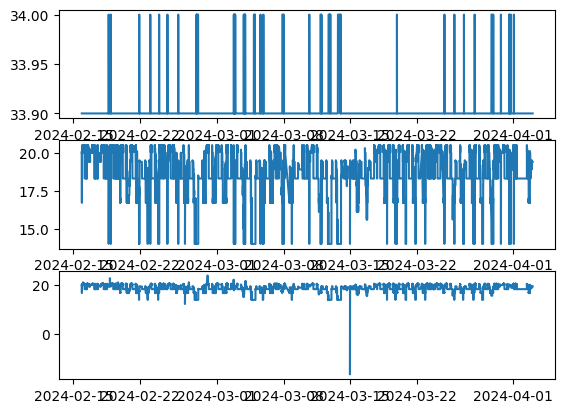

In [5]:
print(new_df.head(10))
print(full_df.head(10))

#target.loc[target["target_temp_low"]>25, "target_temp_low"] = 20.5
plt.subplot(311)
plt.plot(new_df['_time'], target["target_temp_high"], )
plt.subplot(312)
plt.plot(new_df['_time'], target["target_temp_low"])
plt.subplot(313)
plt.plot(full_df['_time'], full_df["temperature"])

In [6]:
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"
mlflow.set_tracking_uri(uri=variables["mlflow"]["url"])
mlflow.set_experiment("Thermostat setpoint")


mlflow.autolog()

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Conv1D, MaxPooling1D, Normalization, Dropout, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import R2Score


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024/04/03 02:10:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/04/03 02:10:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/04/03 02:10:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/04/03 02:10:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


# Data transformation

# Model, pipeline setup and fit

In [7]:
# Define input shape
input_shape = (numeric_features.values.shape[1],) 

mean = np.mean(numeric_features.values)
variance = np.var(numeric_features.values)
print(f"mean: {mean}")
print(f"variance: {variance}")

# Define the model
model = Sequential([
    #Conv1D(32, 8, input_shape=input_shape, activation='relu'),
    # MaxPooling1D(2,2),
    Normalization( input_shape=input_shape, mean=mean, variance=variance, axis=None),
    Reshape((3,6)),
    LSTM(256, return_sequences=True),
    # Conv2D(128, (2,3), activation='relu'),
    # MaxPooling2D(1,2),
    # Conv1D(256, 1, activation='relu'),
    # MaxPooling1D(1,2),
    Flatten(),
    Dense(512, kernel_initializer='normal', activation='relu'),
    Dropout(0.5),
    Dense(512, kernel_initializer='normal', activation='relu'),
    Dropout(0.5),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dropout(0.5),
    Dense(128, kernel_initializer='normal', activation='relu'),
    Dropout(0.5),
    Dense(2, kernel_initializer='normal')  # 2 output targets
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[R2Score(), 'mse', 'mae', 'mape'])

# Display the model summary
model.summary()


/workspaces/python/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


mean: 19.377714592647983
variance: 4422.0576764147645


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 256)         │       269,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,178 (4.16 MB)

 Trainable params: 1,090,178 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
batch_size = 25
epochs = 100

history = model.fit(numeric_features.values, target.values, epochs=epochs, validation_split=0.2)

run_dict =  mlflow.last_active_run().to_dictionary() 
print(run_dict)

mlflow.end_run()

2024/04/03 02:10:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings"
2024/04/03 02:10:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e3d4960c31e54f64bfd8fe0cd96a9366', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/04/03 02:10:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly adv

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Epoch 1/100
4046/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1490 - mae: 4.1490 - mape: 16.2025 - mse: 38.7627 - r2_score: 1170.8512

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 4.1479 - mae: 4.1479 - mape: 16.1981 - mse: 38.7383 - r2_score: 1167.5323 - val_loss: 1.4464 - val_mae: 1.4465 - val_mape: 5.8060 - val_mse: 2.6264 - val_r2_score: 83.0799
Epoch 2/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5537 - mae: 2.5537 - mape: 10.1110 - mse: 10.7029 - r2_score: 437.8769

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 2.5537 - mae: 2.5537 - mape: 10.1109 - mse: 10.7028 - r2_score: 437.5518 - val_loss: 0.6211 - val_mae: 0.6212 - val_mape: 3.1464 - val_mse: 0.9329 - val_r2_score: 3.2519
Epoch 3/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 2.2494 - mae: 2.2494 - mape: 8.9467 - mse: 8.3158 - r2_score: 221.2145 - val_loss: 0.6438 - val_mae: 0.6439 - val_mape: 3.0835 - val_mse: 0.7144 - val_r2_score: 5.0588
Epoch 4/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 2.0928 - mae: 2.0928 - mape: 8.1920 - mse: 7.2339 - r2_score: -16587.5098

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9102 - mae: 1.9102 - mape: 7.5644 - mse: 6.0239 - r2_score: -115.3478

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 1.9102 - mae: 1.9102 - mape: 7.5644 - mse: 6.0238 - r2_score: -115.4295 - val_loss: 0.4843 - val_mae: 0.4844 - val_mape: 2.6520 - val_mse: 0.6962 - val_r2_score: 0.8732
Epoch 5/100
4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7348 - mae: 1.7348 - mape: 6.8764 - mse: 4.9662 - r2_score: -278.0668

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 1.7347 - mae: 1.7347 - mape: 6.8763 - mse: 4.9661 - r2_score: -278.0821 - val_loss: 0.4572 - val_mae: 0.4573 - val_mape: 2.4658 - val_mse: 0.6125 - val_r2_score: 0.7848
Epoch 6/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 1.6251 - mae: 1.6251 - mape: 6.4381 - mse: 4.3786 - r2_score: 11.6995 - val_loss: 0.4879 - val_mae: 0.4881 - val_mape: 2.4574 - val_mse: 0.5731 - val_r2_score: 2.6180
Epoch 7/100


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5108 - mae: 1.5108 - mape: 5.9731 - mse: 3.8118 - r2_score: 203.9385

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 1.5108 - mae: 1.5108 - mape: 5.9730 - mse: 3.8118 - r2_score: 203.7224 - val_loss: 0.4188 - val_mae: 0.4189 - val_mape: 2.0346 - val_mse: 0.4268 - val_r2_score: 2.3847
Epoch 8/100
4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3979 - mae: 1.3979 - mape: 5.4633 - mse: 3.3308 - r2_score: -3.6883

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 1.3978 - mae: 1.3978 - mape: 5.4632 - mse: 3.3307 - r2_score: -3.8131 - val_loss: 0.4183 - val_mae: 0.4183 - val_mape: 2.1432 - val_mse: 0.5408 - val_r2_score: 1.2192
Epoch 9/100
4046/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2725 - mae: 1.2725 - mape: 4.9396 - mse: 2.8050 - r2_score: 116.2100

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 1.2725 - mae: 1.2725 - mape: 4.9395 - mse: 2.8049 - r2_score: 115.8274 - val_loss: 0.2760 - val_mae: 0.2760 - val_mape: 1.4441 - val_mse: 0.2848 - val_r2_score: 1.2902
Epoch 10/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 1.1721 - mae: 1.1721 - mape: 4.5363 - mse: 2.4219 - r2_score: 109.8118 - val_loss: 0.3576 - val_mae: 0.3577 - val_mape: 1.6755 - val_mse: 0.3294 - val_r2_score: 2.9898
Epoch 11/100


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4044/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0928 - mae: 1.0928 - mape: 4.2514 - mse: 2.1087 - r2_score: 109.3962

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 1.0928 - mae: 1.0928 - mape: 4.2513 - mse: 2.1086 - r2_score: 108.9753 - val_loss: 0.3485 - val_mae: 0.3484 - val_mape: 1.6388 - val_mse: 0.3479 - val_r2_score: 2.9475
Epoch 12/100
4047/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9925 - mae: 0.9925 - mape: 3.8660 - mse: 1.7637 - r2_score: -160.3930

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.9925 - mae: 0.9925 - mape: 3.8659 - mse: 1.7636 - r2_score: -160.3238 - val_loss: 0.2532 - val_mae: 0.2533 - val_mape: 1.4017 - val_mse: 0.3265 - val_r2_score: 1.0764
Epoch 13/100
4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9149 - mae: 0.9149 - mape: 3.5754 - mse: 1.5109 - r2_score: 104.3037

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.9149 - mae: 0.9149 - mape: 3.5754 - mse: 1.5108 - r2_score: 104.1605 - val_loss: 0.2519 - val_mae: 0.2519 - val_mape: 1.3270 - val_mse: 0.2814 - val_r2_score: 0.9864
Epoch 14/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.8384 - mae: 0.8384 - mape: 3.3084 - mse: 1.2771 - r2_score: -84.3196 - val_loss: 0.3042 - val_mae: 0.3043 - val_mape: 1.4066 - val_mse: 0.2808 - val_r2_score: 2.7449
Epoch 15/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.7679 - mae: 0.7679 - mape: 3.0201 - mse: 1.0049 - r2_score: 4633.3862  

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7589 - mae: 0.7589 - mape: 3.0246 - mse: 1.0537 - r2_score: 106.2052

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.7589 - mae: 0.7589 - mape: 3.0245 - mse: 1.0537 - r2_score: 106.0850 - val_loss: 0.2278 - val_mae: 0.2278 - val_mape: 1.1830 - val_mse: 0.2494 - val_r2_score: 1.1305
Epoch 16/100
4047/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6824 - mae: 0.6824 - mape: 2.7615 - mse: 0.8642 - r2_score: -29.6336

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.6824 - mae: 0.6824 - mape: 2.7615 - mse: 0.8642 - r2_score: -29.6667 - val_loss: 0.2125 - val_mae: 0.2126 - val_mape: 1.1735 - val_mse: 0.2645 - val_r2_score: 0.9496
Epoch 17/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.6053 - mae: 0.6053 - mape: 2.4925 - mse: 0.6916 - r2_score: 15.8306 - val_loss: 0.3870 - val_mae: 0.3870 - val_mape: 1.9707 - val_mse: 0.4499 - val_r2_score: 1.7797
Epoch 18/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.6045 - mae: 0.6045 - mape: 2.7031 - mse: 0.7477 - r2_score: 924.8692  

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4047/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5393 - mae: 0.5393 - mape: 2.2920 - mse: 0.5722 - r2_score: 9.9948 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.5393 - mae: 0.5393 - mape: 2.2919 - mse: 0.5721 - r2_score: 9.9628 - val_loss: 0.2999 - val_mae: 0.3000 - val_mape: 1.4403 - val_mse: 0.2925 - val_r2_score: 2.1197
Epoch 19/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4543 - mae: 0.4543 - mape: 1.9740 - mse: 0.4327 - r2_score: -4.9620

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.4543 - mae: 0.4543 - mape: 1.9739 - mse: 0.4327 - r2_score: -4.9649 - val_loss: 0.2147 - val_mae: 0.2147 - val_mape: 1.1519 - val_mse: 0.2470 - val_r2_score: 1.0348
Epoch 20/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.3792 - mae: 0.3792 - mape: 1.7229 - mse: 0.3430 - r2_score: 5.0255 - val_loss: 0.2232 - val_mae: 0.2233 - val_mape: 1.1983 - val_mse: 0.2699 - val_r2_score: 0.9851
Epoch 21/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.3068 - mae: 0.3068 - mape: 1.3916 - mse: 0.1873 - r2_score: -151.3329

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.3125 - mae: 0.3125 - mape: 1.5127 - mse: 0.2903 - r2_score: -5.5254 - val_loss: 0.2277 - val_mae: 0.2278 - val_mape: 1.2204 - val_mse: 0.2646 - val_r2_score: 0.9689
Epoch 22/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.2378 - mae: 0.2378 - mape: 1.2104 - mse: 0.1915 - r2_score: -22.8117

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2282 - mae: 0.2282 - mape: 1.2111 - mse: 0.2366 - r2_score: 1.0718

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.2282 - mae: 0.2282 - mape: 1.2110 - mse: 0.2366 - r2_score: 1.0715 - val_loss: 0.1656 - val_mae: 0.1656 - val_mape: 0.9603 - val_mse: 0.2636 - val_r2_score: 0.8659
Epoch 23/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1756 - mae: 0.1756 - mape: 1.0176 - mse: 0.2350 - r2_score: 0.8959 - val_loss: 0.1763 - val_mae: 0.1764 - val_mape: 1.0135 - val_mse: 0.2510 - val_r2_score: 0.8716
Epoch 24/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1620 - mae: 0.1620 - mape: 0.8946 - mse: 0.1241 - r2_score: 0.9323

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4045/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1644 - mae: 0.1644 - mape: 0.9527 - mse: 0.2188 - r2_score: 0.9185

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1644 - mae: 0.1644 - mape: 0.9527 - mse: 0.2188 - r2_score: 0.9185 - val_loss: 0.1662 - val_mae: 0.1663 - val_mape: 0.9542 - val_mse: 0.2458 - val_r2_score: 0.8742
Epoch 25/100
4047/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1631 - mae: 0.1631 - mape: 0.9465 - mse: 0.2168 - r2_score: 0.9206

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1631 - mae: 0.1631 - mape: 0.9465 - mse: 0.2168 - r2_score: 0.9205 - val_loss: 0.1532 - val_mae: 0.1533 - val_mape: 0.9022 - val_mse: 0.2568 - val_r2_score: 0.8678
Epoch 26/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1656 - mae: 0.1656 - mape: 0.9627 - mse: 0.2263 - r2_score: 0.9145 - val_loss: 0.1601 - val_mae: 0.1601 - val_mape: 0.9444 - val_mse: 0.2840 - val_r2_score: 0.8536
Epoch 27/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.2048 - mae: 0.2048 - mape: 1.2582 - mse: 0.3785 - r2_score: -0.1641

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1726 - mae: 0.1726 - mape: 1.0029 - mse: 0.2407 - r2_score: 0.9030 - val_loss: 0.1808 - val_mae: 0.1809 - val_mape: 1.0325 - val_mse: 0.2611 - val_r2_score: 0.8656
Epoch 28/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1409 - mae: 0.1409 - mape: 0.7872 - mse: 0.1508 - r2_score: 1.4634

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4047/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1681 - mae: 0.1681 - mape: 0.9779 - mse: 0.2364 - r2_score: 0.9151

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1681 - mae: 0.1681 - mape: 0.9779 - mse: 0.2364 - r2_score: 0.9151 - val_loss: 0.1696 - val_mae: 0.1696 - val_mape: 0.9800 - val_mse: 0.2542 - val_r2_score: 0.8700
Epoch 29/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1734 - mae: 0.1734 - mape: 1.0085 - mse: 0.2451 - r2_score: 0.9045 - val_loss: 0.2888 - val_mae: 0.2889 - val_mape: 1.6417 - val_mse: 0.4584 - val_r2_score: 0.7621
Epoch 30/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.2325 - mae: 0.2325 - mape: 1.3332 - mse: 0.3456 - r2_score: 1.0594 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1831 - mae: 0.1831 - mape: 1.0609 - mse: 0.2639 - r2_score: 0.8991

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1831 - mae: 0.1831 - mape: 1.0608 - mse: 0.2639 - r2_score: 0.8991 - val_loss: 0.1847 - val_mae: 0.1846 - val_mape: 1.0472 - val_mse: 0.2542 - val_r2_score: 0.8692
Epoch 31/100
4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1655 - mae: 0.1655 - mape: 0.9605 - mse: 0.2285 - r2_score: 0.9086

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1655 - mae: 0.1655 - mape: 0.9605 - mse: 0.2285 - r2_score: 0.9086 - val_loss: 0.1578 - val_mae: 0.1578 - val_mape: 0.9146 - val_mse: 0.2353 - val_r2_score: 0.8793
Epoch 32/100
4044/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1638 - mae: 0.1638 - mape: 0.9509 - mse: 0.2269 - r2_score: 0.9221

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1639 - mae: 0.1639 - mape: 0.9510 - mse: 0.2269 - r2_score: 0.9220 - val_loss: 0.1521 - val_mae: 0.1522 - val_mape: 0.8920 - val_mse: 0.2536 - val_r2_score: 0.8695
Epoch 33/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.1653 - mae: 0.1653 - mape: 0.9606 - mse: 0.2300 - r2_score: 0.9005 - val_loss: 0.1547 - val_mae: 0.1547 - val_mape: 0.9088 - val_mse: 0.2576 - val_r2_score: 0.8675
Epoch 34/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.1616 - mae: 0.1616 - mape: 0.9204 - mse: 0.2136 - r2_score: 0.7308 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1610 - mae: 0.1610 - mape: 0.9353 - mse: 0.2174 - r2_score: 0.9060 - val_loss: 0.1700 - val_mae: 0.1701 - val_mape: 0.9830 - val_mse: 0.2637 - val_r2_score: 0.8645
Epoch 35/100
  22/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1640 - mae: 0.1640 - mape: 0.9713 - mse: 0.2146 - r2_score: 0.6070

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4043/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1623 - mae: 0.1623 - mape: 0.9440 - mse: 0.2197 - r2_score: 0.9167

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1623 - mae: 0.1623 - mape: 0.9440 - mse: 0.2198 - r2_score: 0.9166 - val_loss: 0.1547 - val_mae: 0.1548 - val_mape: 0.8919 - val_mse: 0.2348 - val_r2_score: 0.8796
Epoch 36/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1615 - mae: 0.1615 - mape: 0.9393 - mse: 0.2208 - r2_score: 0.9135 - val_loss: 0.1680 - val_mae: 0.1681 - val_mape: 0.9951 - val_mse: 0.3377 - val_r2_score: 0.8248
Epoch 37/100
  25/4050 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.1709 - mae: 0.1709 - mape: 1.0077 - mse: 0.2704 - r2_score: 1.3788

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1654 - mae: 0.1654 - mape: 0.9621 - mse: 0.2312 - r2_score: 0.9225 - val_loss: 0.2711 - val_mae: 0.2712 - val_mape: 1.5414 - val_mse: 0.4337 - val_r2_score: 0.7734
Epoch 38/100
  16/4050 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.3180 - mae: 0.3180 - mape: 1.8570 - mse: 0.5975 - r2_score: 0.1424

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4045/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2138 - mae: 0.2138 - mape: 1.2415 - mse: 0.3385 - r2_score: 0.8604

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.2137 - mae: 0.2137 - mape: 1.2413 - mse: 0.3384 - r2_score: 0.8605 - val_loss: 0.1623 - val_mae: 0.1624 - val_mape: 0.9465 - val_mse: 0.2713 - val_r2_score: 0.8602
Epoch 39/100
4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1597 - mae: 0.1597 - mape: 0.9315 - mse: 0.2217 - r2_score: 0.8920

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1597 - mae: 0.1597 - mape: 0.9315 - mse: 0.2217 - r2_score: 0.8920 - val_loss: 0.1506 - val_mae: 0.1506 - val_mape: 0.8805 - val_mse: 0.2439 - val_r2_score: 0.8747
Epoch 40/100
4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1698 - mae: 0.1698 - mape: 0.9876 - mse: 0.2394 - r2_score: 0.9131

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1698 - mae: 0.1698 - mape: 0.9876 - mse: 0.2394 - r2_score: 0.9131 - val_loss: 0.1436 - val_mae: 0.1437 - val_mape: 0.8480 - val_mse: 0.2440 - val_r2_score: 0.8751
Epoch 41/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1645 - mae: 0.1645 - mape: 0.9542 - mse: 0.2316 - r2_score: 0.9038 - val_loss: 0.2700 - val_mae: 0.2701 - val_mape: 1.5584 - val_mse: 0.4515 - val_r2_score: 0.7640
Epoch 42/100
  25/4050 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.2439 - mae: 0.2439 - mape: 1.4208 - mse: 0.4487 - r2_score: 0.6443

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4043/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1710 - mae: 0.1710 - mape: 0.9922 - mse: 0.2425 - r2_score: 0.9222

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1710 - mae: 0.1710 - mape: 0.9922 - mse: 0.2425 - r2_score: 0.9221 - val_loss: 0.1533 - val_mae: 0.1534 - val_mape: 0.9002 - val_mse: 0.2667 - val_r2_score: 0.8627
Epoch 43/100
4043/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1641 - mae: 0.1641 - mape: 0.9524 - mse: 0.2284 - r2_score: 0.9097

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1640 - mae: 0.1640 - mape: 0.9523 - mse: 0.2284 - r2_score: 0.9096 - val_loss: 0.1465 - val_mae: 0.1465 - val_mape: 0.8537 - val_mse: 0.2260 - val_r2_score: 0.8842
Epoch 44/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1519 - mae: 0.1519 - mape: 0.8832 - mse: 0.2025 - r2_score: 0.9199 - val_loss: 0.1662 - val_mae: 0.1663 - val_mape: 0.9639 - val_mse: 0.2772 - val_r2_score: 0.8574
Epoch 45/100
  25/4050 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.1449 - mae: 0.1449 - mape: 0.8084 - mse: 0.1448 - r2_score: 1.2836

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1599 - mae: 0.1599 - mape: 0.9263 - mse: 0.2133 - r2_score: 0.9222 - val_loss: 0.1710 - val_mae: 0.1710 - val_mape: 0.9981 - val_mse: 0.2829 - val_r2_score: 0.8540
Epoch 46/100
  23/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1293 - mae: 0.1293 - mape: 0.7230 - mse: 0.1123 - r2_score: 0.9835

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4047/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1670 - mae: 0.1670 - mape: 0.9681 - mse: 0.2371 - r2_score: 0.8839

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1670 - mae: 0.1670 - mape: 0.9681 - mse: 0.2371 - r2_score: 0.8839 - val_loss: 0.1590 - val_mae: 0.1591 - val_mape: 0.9251 - val_mse: 0.2788 - val_r2_score: 0.8562
Epoch 47/100
4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1617 - mae: 0.1617 - mape: 0.9400 - mse: 0.2286 - r2_score: 0.9112

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1617 - mae: 0.1617 - mape: 0.9400 - mse: 0.2286 - r2_score: 0.9112 - val_loss: 0.1424 - val_mae: 0.1425 - val_mape: 0.8391 - val_mse: 0.2450 - val_r2_score: 0.8744
Epoch 48/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1688 - mae: 0.1688 - mape: 0.9811 - mse: 0.2386 - r2_score: 0.8847 - val_loss: 0.1437 - val_mae: 0.1438 - val_mape: 0.8428 - val_mse: 0.2397 - val_r2_score: 0.8769
Epoch 49/100
  25/4050 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.1698 - mae: 0.1698 - mape: 1.0128 - mse: 0.2823 - r2_score: 0.6784

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1549 - mae: 0.1549 - mape: 0.9002 - mse: 0.2101 - r2_score: 0.9270 - val_loss: 0.2489 - val_mae: 0.2490 - val_mape: 1.3844 - val_mse: 0.4182 - val_r2_score: 0.7818
Epoch 50/100
  25/4050 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.2179 - mae: 0.2179 - mape: 1.2543 - mse: 0.3541 - r2_score: 0.2127

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1705 - mae: 0.1705 - mape: 0.9904 - mse: 0.2418 - r2_score: 0.8821

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1705 - mae: 0.1705 - mape: 0.9904 - mse: 0.2418 - r2_score: 0.8821 - val_loss: 0.1536 - val_mae: 0.1536 - val_mape: 0.8981 - val_mse: 0.2770 - val_r2_score: 0.8572
Epoch 51/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1794 - mae: 0.1794 - mape: 1.0423 - mse: 0.2640 - r2_score: 0.8981 - val_loss: 0.1638 - val_mae: 0.1639 - val_mape: 0.9468 - val_mse: 0.2516 - val_r2_score: 0.8707
Epoch 52/100
  17/4050 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.1568 - mae: 0.1568 - mape: 0.9129 - mse: 0.2196 - r2_score: 0.6543 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1629 - mae: 0.1629 - mape: 0.9472 - mse: 0.2277 - r2_score: 0.9053 - val_loss: 0.1661 - val_mae: 0.1662 - val_mape: 0.9617 - val_mse: 0.2739 - val_r2_score: 0.8586
Epoch 53/100
  17/4050 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.1381 - mae: 0.1381 - mape: 0.8029 - mse: 0.1536 - r2_score: 0.4183 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4045/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1566 - mae: 0.1566 - mape: 0.9097 - mse: 0.2140 - r2_score: 0.9165

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1566 - mae: 0.1566 - mape: 0.9097 - mse: 0.2140 - r2_score: 0.9165 - val_loss: 0.1401 - val_mae: 0.1402 - val_mape: 0.8243 - val_mse: 0.2390 - val_r2_score: 0.8775
Epoch 54/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1607 - mae: 0.1607 - mape: 0.9316 - mse: 0.2183 - r2_score: 0.9196 - val_loss: 0.1644 - val_mae: 0.1645 - val_mape: 0.9596 - val_mse: 0.2969 - val_r2_score: 0.8466
Epoch 55/100
  17/4050 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.1325 - mae: 0.1325 - mape: 0.7461 - mse: 0.1494 - r2_score: 0.7441

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2240 - mae: 0.2240 - mape: 1.2845 - mse: 0.3580 - r2_score: 0.8657

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.2240 - mae: 0.2240 - mape: 1.2843 - mse: 0.3580 - r2_score: 0.8657 - val_loss: 0.1493 - val_mae: 0.1494 - val_mape: 0.8812 - val_mse: 0.2548 - val_r2_score: 0.8692
Epoch 56/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1596 - mae: 0.1596 - mape: 0.9255 - mse: 0.2181 - r2_score: 0.9425 - val_loss: 0.1638 - val_mae: 0.1638 - val_mape: 0.9546 - val_mse: 0.2878 - val_r2_score: 0.8513
Epoch 57/100
  16/4050 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.1525 - mae: 0.1525 - mape: 0.8780 - mse: 0.1911 - r2_score: 1.0805

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1536 - mae: 0.1536 - mape: 0.8891 - mse: 0.2044 - r2_score: 0.9200 - val_loss: 0.1867 - val_mae: 0.1867 - val_mape: 1.0970 - val_mse: 0.3316 - val_r2_score: 0.8280
Epoch 58/100
  17/4050 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.1590 - mae: 0.1590 - mape: 0.8994 - mse: 0.1831 - r2_score: 1.5190

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1567 - mae: 0.1567 - mape: 0.9094 - mse: 0.2127 - r2_score: 0.9132 - val_loss: 0.2744 - val_mae: 0.2745 - val_mape: 1.6108 - val_mse: 0.5175 - val_r2_score: 0.7295
Epoch 59/100
  16/4050 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.2892 - mae: 0.2892 - mape: 1.6961 - mse: 0.5373 - r2_score: -0.3073 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4045/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1680 - mae: 0.1680 - mape: 0.9767 - mse: 0.2406 - r2_score: 0.9080

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1680 - mae: 0.1680 - mape: 0.9766 - mse: 0.2406 - r2_score: 0.9080 - val_loss: 0.1608 - val_mae: 0.1608 - val_mape: 0.9424 - val_mse: 0.2702 - val_r2_score: 0.8610
Epoch 60/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1530 - mae: 0.1530 - mape: 0.8862 - mse: 0.2016 - r2_score: 0.9129 - val_loss: 0.1815 - val_mae: 0.1816 - val_mape: 1.0455 - val_mse: 0.3271 - val_r2_score: 0.8303
Epoch 61/100
  22/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1525 - mae: 0.1525 - mape: 0.8670 - mse: 0.1790 - r2_score: 0.7675

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4047/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1550 - mae: 0.1550 - mape: 0.9023 - mse: 0.2112 - r2_score: 0.9266

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1550 - mae: 0.1550 - mape: 0.9023 - mse: 0.2112 - r2_score: 0.9266 - val_loss: 0.1727 - val_mae: 0.1727 - val_mape: 1.0025 - val_mse: 0.2822 - val_r2_score: 0.8551
Epoch 62/100
4044/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2023 - mae: 0.2023 - mape: 1.1627 - mse: 0.3047 - r2_score: 0.8794

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.2023 - mae: 0.2023 - mape: 1.1628 - mse: 0.3047 - r2_score: 0.8793 - val_loss: 0.1584 - val_mae: 0.1585 - val_mape: 0.9328 - val_mse: 0.2854 - val_r2_score: 0.8526
Epoch 63/100
4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1581 - mae: 0.1581 - mape: 0.9179 - mse: 0.2178 - r2_score: 0.9131

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1581 - mae: 0.1581 - mape: 0.9179 - mse: 0.2178 - r2_score: 0.9131 - val_loss: 0.1557 - val_mae: 0.1557 - val_mape: 0.9130 - val_mse: 0.2693 - val_r2_score: 0.8617
Epoch 64/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1511 - mae: 0.1511 - mape: 0.8761 - mse: 0.2001 - r2_score: 0.9200

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1511 - mae: 0.1511 - mape: 0.8761 - mse: 0.2001 - r2_score: 0.9200 - val_loss: 0.1517 - val_mae: 0.1518 - val_mape: 0.8826 - val_mse: 0.2368 - val_r2_score: 0.8784
Epoch 65/100
4044/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1624 - mae: 0.1624 - mape: 0.9387 - mse: 0.2294 - r2_score: 0.9103

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1624 - mae: 0.1624 - mape: 0.9388 - mse: 0.2294 - r2_score: 0.9102 - val_loss: 0.1464 - val_mae: 0.1465 - val_mape: 0.8582 - val_mse: 0.2541 - val_r2_score: 0.8692
Epoch 66/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1761 - mae: 0.1761 - mape: 1.0190 - mse: 0.2554 - r2_score: 0.9116 - val_loss: 0.1853 - val_mae: 0.1854 - val_mape: 1.0573 - val_mse: 0.2984 - val_r2_score: 0.8458
Epoch 67/100
  16/4050 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.2148 - mae: 0.2148 - mape: 1.2681 - mse: 0.3925 - r2_score: 0.0502

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1839 - mae: 0.1839 - mape: 1.0618 - mse: 0.2726 - r2_score: 0.8750 - val_loss: 0.1857 - val_mae: 0.1858 - val_mape: 1.0831 - val_mse: 0.3676 - val_r2_score: 0.8089
Epoch 68/100
  17/4050 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.1401 - mae: 0.1401 - mape: 0.8103 - mse: 0.2020 - r2_score: 1.3267 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1473 - mae: 0.1473 - mape: 0.8527 - mse: 0.1893 - r2_score: 0.9362

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1473 - mae: 0.1473 - mape: 0.8527 - mse: 0.1893 - r2_score: 0.9362 - val_loss: 0.1424 - val_mae: 0.1424 - val_mape: 0.8335 - val_mse: 0.2352 - val_r2_score: 0.8796
Epoch 69/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1621 - mae: 0.1621 - mape: 0.9309 - mse: 0.2285 - r2_score: 0.9078 - val_loss: 0.1593 - val_mae: 0.1593 - val_mape: 0.9250 - val_mse: 0.2547 - val_r2_score: 0.8692
Epoch 70/100
  23/4050 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.1715 - mae: 0.1715 - mape: 1.0132 - mse: 0.2960 - r2_score: 0.1951

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1733 - mae: 0.1733 - mape: 1.0024 - mse: 0.2504 - r2_score: 0.8936 - val_loss: 0.1699 - val_mae: 0.1700 - val_mape: 0.9891 - val_mse: 0.2984 - val_r2_score: 0.8457
Epoch 71/100
  15/4050 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1477 - mae: 0.1477 - mape: 0.8744 - mse: 0.1802 - r2_score: 0.2150

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1853 - mae: 0.1853 - mape: 1.0592 - mse: 0.2623 - r2_score: 0.8922

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.1853 - mae: 0.1853 - mape: 1.0592 - mse: 0.2623 - r2_score: 0.8922 - val_loss: 0.1475 - val_mae: 0.1476 - val_mape: 0.8601 - val_mse: 0.2204 - val_r2_score: 0.8874
Epoch 72/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1571 - mae: 0.1571 - mape: 0.9092 - mse: 0.2148 - r2_score: 0.9336 - val_loss: 0.1772 - val_mae: 0.1773 - val_mape: 1.0261 - val_mse: 0.3245 - val_r2_score: 0.8320
Epoch 73/100
  22/4050 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.1226 - mae: 0.1226 - mape: 0.7037 - mse: 0.1051 - r2_score: 0.2800 

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1523 - mae: 0.1523 - mape: 0.8828 - mse: 0.2031 - r2_score: 0.9126

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.1523 - mae: 0.1523 - mape: 0.8828 - mse: 0.2031 - r2_score: 0.9126 - val_loss: 0.1702 - val_mae: 0.1702 - val_mape: 0.9735 - val_mse: 0.2888 - val_r2_score: 0.8525
Epoch 74/100
4041/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1698 - mae: 0.1698 - mape: 0.9861 - mse: 0.2439 - r2_score: 0.8984

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.1698 - mae: 0.1698 - mape: 0.9860 - mse: 0.2439 - r2_score: 0.8984 - val_loss: 0.1446 - val_mae: 0.1446 - val_mape: 0.8472 - val_mse: 0.2552 - val_r2_score: 0.8694
Epoch 75/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1504 - mae: 0.1504 - mape: 0.8679 - mse: 0.1972 - r2_score: 0.9240 - val_loss: 0.1542 - val_mae: 0.1543 - val_mape: 0.9002 - val_mse: 0.2500 - val_r2_score: 0.8713
Epoch 76/100
  32/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1386 - mae: 0.1386 - mape: 0.7924 - mse: 0.1613 - r2_score: 1.0281

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1709 - mae: 0.1709 - mape: 0.9823 - mse: 0.2372 - r2_score: 0.8997 - val_loss: 0.1605 - val_mae: 0.1606 - val_mape: 0.9302 - val_mse: 0.2626 - val_r2_score: 0.8645
Epoch 77/100
  32/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1162 - mae: 0.1162 - mape: 0.6676 - mse: 0.1170 - r2_score: 1.3953

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1544 - mae: 0.1544 - mape: 0.8925 - mse: 0.2060 - r2_score: 0.9232 - val_loss: 0.1713 - val_mae: 0.1714 - val_mape: 0.9934 - val_mse: 0.2945 - val_r2_score: 0.8489
Epoch 78/100
  34/4050 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.1285 - mae: 0.1285 - mape: 0.7377 - mse: 0.1345 - r2_score: 1.0282

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1711 - mae: 0.1711 - mape: 0.9819 - mse: 0.2352 - r2_score: 0.9111 - val_loss: 0.1778 - val_mae: 0.1779 - val_mape: 1.0215 - val_mse: 0.2842 - val_r2_score: 0.8535
Epoch 79/100
  34/4050 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.1355 - mae: 0.1355 - mape: 0.7859 - mse: 0.1504 - r2_score: 0.6061

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1478 - mae: 0.1478 - mape: 0.8555 - mse: 0.1914 - r2_score: 0.9044 - val_loss: 0.2888 - val_mae: 0.2889 - val_mape: 1.6669 - val_mse: 0.5098 - val_r2_score: 0.7333
Epoch 80/100
  32/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.2665 - mae: 0.2665 - mape: 1.5791 - mse: 0.4740 - r2_score: 0.0153

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4040/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2003 - mae: 0.2003 - mape: 1.1518 - mse: 0.2931 - r2_score: 0.8587

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.2003 - mae: 0.2003 - mape: 1.1515 - mse: 0.2929 - r2_score: 0.8588 - val_loss: 0.1598 - val_mae: 0.1599 - val_mape: 0.9244 - val_mse: 0.2639 - val_r2_score: 0.8666
Epoch 81/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1604 - mae: 0.1604 - mape: 0.9272 - mse: 0.2224 - r2_score: 0.9154 - val_loss: 0.1812 - val_mae: 0.1813 - val_mape: 1.0565 - val_mse: 0.3871 - val_r2_score: 0.7985
Epoch 82/100
  33/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1370 - mae: 0.1370 - mape: 0.8061 - mse: 0.1766 - r2_score: 0.1979

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4046/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1525 - mae: 0.1525 - mape: 0.8823 - mse: 0.2055 - r2_score: 0.9198

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1525 - mae: 0.1525 - mape: 0.8823 - mse: 0.2055 - r2_score: 0.9197 - val_loss: 0.1374 - val_mae: 0.1374 - val_mape: 0.8008 - val_mse: 0.2193 - val_r2_score: 0.8877
Epoch 83/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1590 - mae: 0.1590 - mape: 0.9221 - mse: 0.2215 - r2_score: 0.9020 - val_loss: 0.1719 - val_mae: 0.1720 - val_mape: 0.9887 - val_mse: 0.2866 - val_r2_score: 0.8518
Epoch 84/100
  34/4050 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.1274 - mae: 0.1274 - mape: 0.7108 - mse: 0.1067 - r2_score: 1.0970

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4045/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1514 - mae: 0.1514 - mape: 0.8746 - mse: 0.2005 - r2_score: 0.9161

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1514 - mae: 0.1514 - mape: 0.8747 - mse: 0.2005 - r2_score: 0.9160 - val_loss: 0.1422 - val_mae: 0.1422 - val_mape: 0.8382 - val_mse: 0.2490 - val_r2_score: 0.8722
Epoch 85/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1516 - mae: 0.1516 - mape: 0.8770 - mse: 0.2034 - r2_score: 0.8985 - val_loss: 0.1535 - val_mae: 0.1535 - val_mape: 0.8923 - val_mse: 0.2493 - val_r2_score: 0.8718
Epoch 86/100
  32/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1395 - mae: 0.1395 - mape: 0.8079 - mse: 0.1635 - r2_score: 1.3706

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4049/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1618 - mae: 0.1618 - mape: 0.9359 - mse: 0.2254 - r2_score: 0.8976

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1618 - mae: 0.1618 - mape: 0.9359 - mse: 0.2253 - r2_score: 0.8976 - val_loss: 0.1525 - val_mae: 0.1526 - val_mape: 0.8818 - val_mse: 0.2423 - val_r2_score: 0.8754
Epoch 87/100
4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1661 - mae: 0.1661 - mape: 0.9596 - mse: 0.2366 - r2_score: 0.8980

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.1661 - mae: 0.1661 - mape: 0.9596 - mse: 0.2366 - r2_score: 0.8980 - val_loss: 0.1426 - val_mae: 0.1427 - val_mape: 0.8359 - val_mse: 0.2425 - val_r2_score: 0.8755
Epoch 88/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1482 - mae: 0.1482 - mape: 0.8597 - mse: 0.1967 - r2_score: 0.9383 - val_loss: 0.1711 - val_mae: 0.1712 - val_mape: 0.9635 - val_mse: 0.2715 - val_r2_score: 0.8602
Epoch 89/100
  32/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1694 - mae: 0.1694 - mape: 0.9644 - mse: 0.1928 - r2_score: 0.6611

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4045/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1508 - mae: 0.1508 - mape: 0.8702 - mse: 0.1956 - r2_score: 0.8841

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1508 - mae: 0.1508 - mape: 0.8702 - mse: 0.1956 - r2_score: 0.8842 - val_loss: 0.1448 - val_mae: 0.1449 - val_mape: 0.8431 - val_mse: 0.2271 - val_r2_score: 0.8843
Epoch 90/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1581 - mae: 0.1581 - mape: 0.9102 - mse: 0.2203 - r2_score: 0.9061 - val_loss: 0.1704 - val_mae: 0.1704 - val_mape: 0.9753 - val_mse: 0.2735 - val_r2_score: 0.8586
Epoch 91/100
  32/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1387 - mae: 0.1387 - mape: 0.7938 - mse: 0.1581 - r2_score: 1.3297

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4045/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1464 - mae: 0.1464 - mape: 0.8446 - mse: 0.1866 - r2_score: 0.9276

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1464 - mae: 0.1464 - mape: 0.8447 - mse: 0.1866 - r2_score: 0.9276 - val_loss: 0.1599 - val_mae: 0.1600 - val_mape: 0.9245 - val_mse: 0.2728 - val_r2_score: 0.8606
Epoch 92/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1468 - mae: 0.1468 - mape: 0.8451 - mse: 0.1896 - r2_score: 0.9258 - val_loss: 0.2716 - val_mae: 0.2717 - val_mape: 1.5814 - val_mse: 0.5274 - val_r2_score: 0.7231
Epoch 93/100
  33/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.2643 - mae: 0.2643 - mape: 1.5387 - mse: 0.5034 - r2_score: 0.1731

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4044/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1615 - mae: 0.1615 - mape: 0.9311 - mse: 0.2248 - r2_score: 0.9095

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1615 - mae: 0.1615 - mape: 0.9311 - mse: 0.2248 - r2_score: 0.9095 - val_loss: 0.1468 - val_mae: 0.1469 - val_mape: 0.8493 - val_mse: 0.2313 - val_r2_score: 0.8820
Epoch 94/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1590 - mae: 0.1590 - mape: 0.9221 - mse: 0.2225 - r2_score: 0.9060 - val_loss: 0.1545 - val_mae: 0.1546 - val_mape: 0.8980 - val_mse: 0.2648 - val_r2_score: 0.8645
Epoch 95/100
  33/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1318 - mae: 0.1318 - mape: 0.7570 - mse: 0.1655 - r2_score: 0.7458

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1540 - mae: 0.1540 - mape: 0.8918 - mse: 0.2098 - r2_score: 0.9200 - val_loss: 0.1552 - val_mae: 0.1553 - val_mape: 0.8978 - val_mse: 0.2661 - val_r2_score: 0.8624
Epoch 96/100
  33/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1495 - mae: 0.1495 - mape: 0.8609 - mse: 0.2029 - r2_score: 0.8408

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1459 - mae: 0.1459 - mape: 0.8436 - mse: 0.1904 - r2_score: 0.9234 - val_loss: 0.1553 - val_mae: 0.1554 - val_mape: 0.8975 - val_mse: 0.2537 - val_r2_score: 0.8699
Epoch 97/100
  30/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1305 - mae: 0.1305 - mape: 0.7368 - mse: 0.1280 - r2_score: 1.4406

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4040/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1523 - mae: 0.1523 - mape: 0.8813 - mse: 0.2054 - r2_score: 0.9342

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1523 - mae: 0.1523 - mape: 0.8814 - mse: 0.2054 - r2_score: 0.9341 - val_loss: 0.1493 - val_mae: 0.1493 - val_mape: 0.8672 - val_mse: 0.2619 - val_r2_score: 0.8659
Epoch 98/100
4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1444 - mae: 0.1444 - mape: 0.8356 - mse: 0.1874 - r2_score: 0.9208 - val_loss: 0.1726 - val_mae: 0.1727 - val_mape: 1.0002 - val_mse: 0.3030 - val_r2_score: 0.8448
Epoch 99/100
  32/4050 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1561 - mae: 0.1561 - mape: 0.9144 - mse: 0.2120 - r2_score: 0.0180

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1447 - mae: 0.1447 - mape: 0.8383 - mse: 0.1892 - r2_score: 0.9223

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1447 - mae: 0.1447 - mape: 0.8383 - mse: 0.1892 - r2_score: 0.9223 - val_loss: 0.1689 - val_mae: 0.1689 - val_mape: 0.9753 - val_mse: 0.2892 - val_r2_score: 0.8505
Epoch 100/100
4048/4050 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1478 - mae: 0.1478 - mape: 0.8554 - mse: 0.1958 - r2_score: 0.9256

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


4050/4050 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1478 - mae: 0.1478 - mape: 0.8554 - mse: 0.1959 - r2_score: 0.9256 - val_loss: 0.1492 - val_mae: 0.1493 - val_mape: 0.8662 - val_mse: 0.2315 - val_r2_score: 0.8811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


2024/04/03 02:59:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/04/03 02:59:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings"
2024/04/03 02:59:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3

{'info': {'artifact_uri': '/mnt/nfs/mlflow/9/e3d4960c31e54f64bfd8fe0cd96a9366/artifacts', 'end_time': 1712113150484, 'experiment_id': '9', 'lifecycle_stage': 'active', 'run_id': 'e3d4960c31e54f64bfd8fe0cd96a9366', 'run_name': 'enchanting-deer-555', 'run_uuid': 'e3d4960c31e54f64bfd8fe0cd96a9366', 'start_time': 1712110216129, 'status': 'FINISHED', 'user_id': 'vscode'}, 'data': {'metrics': {'loss': 0.15090958774089813, 'mae': 0.150910422205925, 'mape': 0.8743603825569153, 'mse': 0.20491613447666168, 'r2_score': 0.9028564095497131, 'validation_loss': 0.1491832137107849, 'validation_mae': 0.14925526082515717, 'validation_mape': 0.8662377595901489, 'validation_mse': 0.23151913285255432, 'validation_r2_score': 0.8810683488845825, 'val_loss': 0.1491832137107849, 'val_mae': 0.14925526082515717, 'val_mape': 0.8662377595901489, 'val_mse': 0.23151913285255432, 'val_r2_score': 0.8810683488845825}, 'params': {'batch_size': 'None', 'class_weight': 'None', 'epochs': '100', 'initial_epoch': '0', 'opt_a

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [9]:
signature = infer_signature(numeric_features, model.predict(numeric_features))
set_signature(f"runs:/{run_dict['info']['run_id']}/model", signature)

print(numeric_features.head())

5063/5063 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
   in_the_area  presence  in_bed  openweathermap_temperature  \
0          1.0       1.0     0.0                    3.033226   
1          1.0       1.0     0.0                    3.033548   
2          1.0       1.0     0.0                    3.033871   
3          1.0       1.0     0.0                    3.034194   
4          1.0       1.0     0.0                    3.034516   

   outdoor_temperature_increasing_2  outdoor_temperature_decreasing  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   

   thermostat_base_heating_sp  living_room_occupancy  \
0                        20.5                    0.0   
1                        20.5    

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dict_keys(['loss', 'mae', 'mape', 'mse', 'r2_score', 'val_loss', 'val_mae', 'val_mape', 'val_mse', 'val_r2_score'])


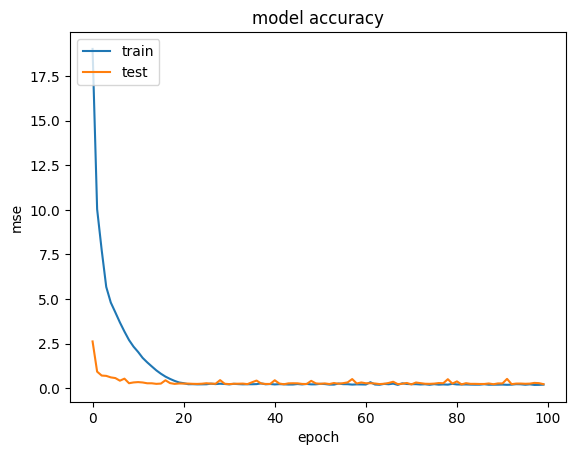

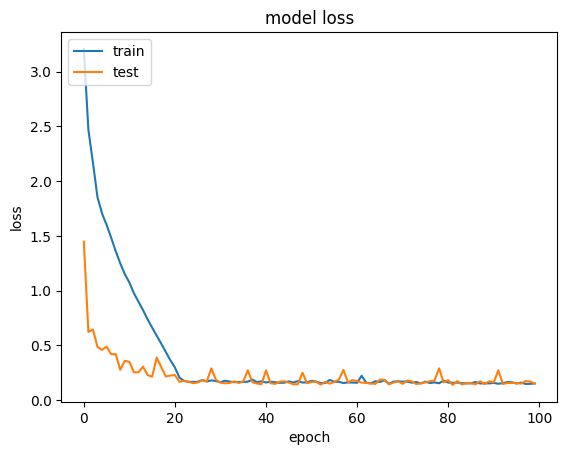

In [10]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:

# with mlflow.start_run() as run:
#     mlflow.autolog()
#     import autokeras as ak
#     os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"
#     mlflow.set_tracking_uri(uri=variables["mlflow"]["url"])
#     mlflow.set_experiment("Thermostat setpoint")
#     signature = infer_signature(numeric_features, model.predict(numeric_features))
#     # define the search
#     search = ak.StructuredDataRegressor(max_trials=100, loss='mean_absolute_error',  metrics=['mse', 'mae', 'mape'])
#     # perform the search
#     history = search.fit(x=numeric_features.values, y=target.values, validation_split=0.2,)

#     mae, mse, mape, _ = search.evaluate(numeric_features.values, target.values, verbose=0)
#     print('MAE: %.3f' % mae)

#     # get the best performing model
#     model = search.export_model()
#     # summarize the loaded model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 256)         │       269,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,270,536 (12.48 MB)

 Trainable params: 1,090,178 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,180,358 (8.32 MB)

In [12]:
# run_dict =  mlflow.last_active_run().to_dictionary() 
# print(run_dict)
# signature = infer_signature(numeric_features, model.predict(numeric_features))
# set_signature(f"runs:/{run_dict['info']['run_id']}/model", signature)

# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['mse'])
# # plt.plot(history.history['val_mse'])
# plt.title('model accuracy')
# plt.ylabel('mse')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# # plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [13]:

# new_df.to_csv('thermostat_2022-23.csv', encoding='utf-8')
#!export MLFLOW_TRACKING_URI=http://192.168.0.2:5051
#!mlflow models build-docker -m runs:/57e811d9acd34c0db02d762d6fa6c31b/model -n paillomams/presence-det --enable-mlserver

#!docker push paillomams/presence-det